# Data Labeling Tutorial: Creating Ground Truth for LLM-as-Judge

## Learning Objectives

By completing this tutorial, you will be able to:
- ✅ Understand manual vs. automated ground truth labeling strategies
- ✅ Create balanced train/dev/test splits using stratified sampling
- ✅ Analyze label distributions and identify imbalances
- ✅ Use GPT-4o for automated labeling (with proper validation)
- ✅ Validate label quality and handle edge cases
- ✅ Export labeled datasets for judge development

## Prerequisites

- Completed [LLM-as-Judge Concepts Tutorial](llm_judge_concepts.md)
- Have collected Recipe Bot traces (from `scripts/generate_traces.py`)
- Understanding of classification metrics

## Estimated Time

**Execution Time:** 15-20 minutes  
**Note:** Automated labeling with GPT-4o costs ~$0.01-0.05 per example

---

## Setup

### Import Libraries and Configure Environment

In [1]:
# Standard library imports
import json
import os
from typing import Any, Dict, Optional, Tuple

# LLM API
import litellm
import matplotlib.pyplot as plt
import numpy as np

# Data manipulation and visualization
import pandas as pd
import seaborn as sns

# Environment configuration
from dotenv import load_dotenv

# ML utilities
from sklearn.model_selection import train_test_split

load_dotenv()

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Setup complete")
print(f"Working directory: {os.getcwd()}")

✅ Setup complete
Working directory: /Users/rajnishkhatri/Documents/recipe-chatbot/homeworks/hw3


## Part 1: Manual vs. Automated Labeling

### Why Ground Truth Labeling Matters

Ground truth labels are the **foundation** of LLM-as-Judge evaluation. These labels:
- Define what "correct" means for your specific criterion
- Enable measurement of judge bias (TPR/TNR)
- Provide few-shot examples for judge prompts

### Labeling Strategies Comparison

| Aspect | Manual Labeling | Automated (LLM) Labeling |
|--------|-----------------|-------------------------|
| **Quality** | Highest (domain expert) | Good (with validation) |
| **Speed** | 50-100 examples/hour | 100s per hour |
| **Cost** | $50-150/hour | $0.01-0.05 per label |
| **Consistency** | Variable (inter-annotator agreement) | Perfect (deterministic) |
| **Edge Cases** | Captures nuance | May miss subtle issues |
| **Best For** | Safety-critical, complex criteria | Clear criteria, rapid iteration |

### ⚠️ Critical Warning About Automated Labeling

Using an LLM (like GPT-4o) to create ground truth for training an LLM-as-Judge means you're essentially **already using an LLM judge**. This is acceptable if:

1. ✅ You use a **much higher-quality model** for ground truth (GPT-4o) than for judging (GPT-4o-mini)
2. ✅ You **manually review at least 30-50%** of automated labels
3. ✅ You validate **no systematic labeling errors** exist
4. ✅ The evaluation criterion is **objective and clear**

**For this homework:** We'll demonstrate automated labeling, but in production, invest in manual labeling by domain experts.

## Part 2: Load and Explore Raw Traces

Let's load the Recipe Bot traces that need labeling.

In [2]:
# Load raw traces
traces_path = "data/raw_traces.csv"

if not os.path.exists(traces_path):
    print(f"❌ File not found: {traces_path}")
    print("Run scripts/generate_traces.py first to create raw traces.")
else:
    df_traces = pd.read_csv(traces_path)
    print(f"✅ Loaded {len(df_traces)} traces from {traces_path}")
    print(f"\nColumns: {list(df_traces.columns)}")
    print("\nFirst trace preview:")
    display(df_traces.head(2))

✅ Loaded 2400 traces from data/raw_traces.csv

Columns: ['query', 'dietary_restriction', 'response', 'success', 'error', 'trace_id', 'query_id']

First trace preview:


,query,dietary_restriction,response,success,error,trace_id,query_id
0,I'm vegan but I really want to make something ...,vegan,Certainly! For a vegan yogurt breakfast that m...,True,NaN,1_8,1
1,I'm vegan but I really want to make something ...,vegan,Absolutely! While honey is a popular sweetener...,True,NaN,1_9,1


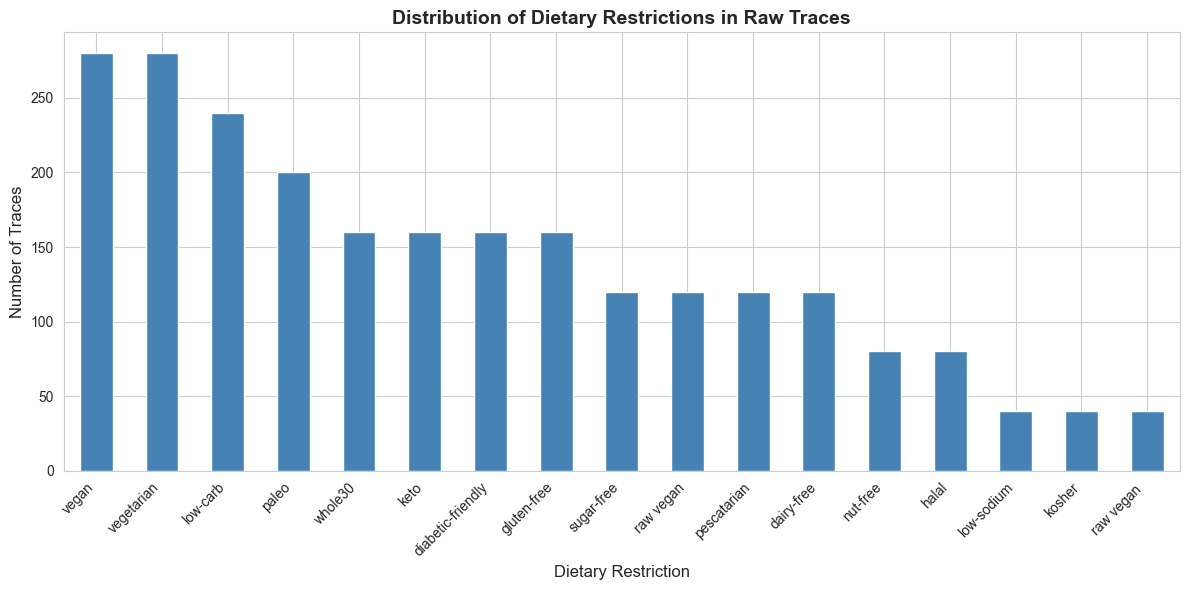


📊 Total traces per restriction:
dietary_restriction
vegan                280
vegetarian           280
low-carb             240
paleo                200
whole30              160
keto                 160
diabetic-friendly    160
gluten-free          160
sugar-free           120
raw vegan            120
pescatarian          120
dairy-free           120
nut-free              80
halal                 80
low-sodium            40
kosher                40
raw vegan             40
Name: count, dtype: int64


In [3]:
# Analyze dietary restriction distribution
if 'dietary_restriction' in df_traces.columns:
    restriction_counts = df_traces['dietary_restriction'].value_counts()
    
    plt.figure(figsize=(12, 6))
    restriction_counts.plot(kind='bar', color='steelblue')
    plt.title('Distribution of Dietary Restrictions in Raw Traces', fontsize=14, fontweight='bold')
    plt.xlabel('Dietary Restriction', fontsize=12)
    plt.ylabel('Number of Traces', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Total traces per restriction:")
    print(restriction_counts)

## Part 3: Automated Labeling with GPT-4o

### Labeling Prompt Design

The quality of automated labels depends entirely on the labeling prompt. Key components:
1. **Clear role definition** ("You are an expert nutritionist...")
2. **Comprehensive dietary restriction definitions**
3. **Explicit PASS/FAIL criteria**
4. **Structured output format** (JSON with reasoning and confidence)

Let's define our labeling prompt:

In [ ]:
LABELING_PROMPT = """You are an expert nutritionist and dietary specialist. Your task is to evaluate whether a recipe response
properly adheres to the specified dietary restriction.

DIETARY RESTRICTION DEFINITIONS:
- Vegan: No animal products (meat, dairy, eggs, honey, etc.)
- Vegetarian: No meat or fish, but dairy and eggs are allowed
- Gluten-free: No wheat, barley, rye, or other gluten-containing grains
- Dairy-free: No milk, cheese, butter, yogurt, or other dairy products
- Keto: Very low carb (typically <20g net carbs), high fat, moderate protein
- Paleo: No grains, legumes, dairy, refined sugar, or processed foods
- Pescatarian: No meat except fish and seafood
- Kosher: Follows Jewish dietary laws (no pork, shellfish, mixing meat/dairy)
- Halal: Follows Islamic dietary laws (no pork, alcohol, proper slaughter)
- Nut-free: No tree nuts or peanuts
- Low-carb: Significantly reduced carbohydrates (typically <50g per day)
- Sugar-free: No added sugars or high-sugar ingredients
- Raw vegan: Vegan foods not heated above 118°F (48°C)
- Whole30: No grains, dairy, legumes, sugar, alcohol, or processed foods
- Diabetic-friendly: Low glycemic index, controlled carbohydrates
- Low-sodium: Reduced sodium content for heart health

EVALUATION CRITERIA:
- PASS: The recipe clearly adheres to the dietary restriction with appropriate ingredients and preparation methods
- FAIL: The recipe contains ingredients or methods that violate the dietary restriction
- Consider both explicit ingredients and cooking methods
- Be strict but reasonable in your evaluation

Please analyze the query, dietary restriction, and recipe response, then provide your evaluation.

Query: {query}
Dietary Restriction: {dietary_restriction}
Recipe Response: {response}

Provide your analysis in the following JSON format:
{{
    "reasoning": "Detailed explanation of your evaluation, citing specific ingredients or methods",
    "label": "PASS" or "FAIL",
    "confidence": "HIGH", "MEDIUM", or "LOW"
}}"""

print("✅ Labeling prompt defined")
print(f"Prompt length: {len(LABELING_PROMPT)} characters")

✅ Labeling prompt defined
Prompt length: 1969 characters


### Label a Single Example (Demo)

Let's label one example to see how the automated labeling works:

In [7]:
def label_single_example(query: str, dietary_restriction: str, response: str) -> Optional[Dict[str, Any]]:
    """Label a single example using GPT-4o."""
    try:
        prompt = LABELING_PROMPT.format(
            query=query,
            dietary_restriction=dietary_restriction,
            response=response
        )
        
        completion = litellm.completion(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        
        response_text = completion.choices[0].message.content.strip()
        
        # Extract JSON from response
        if "```json" in response_text:
            json_start = response_text.find("```json") + 7
            json_end = response_text.find("```", json_start)
            json_text = response_text[json_start:json_end].strip()
        elif "{" in response_text and "}" in response_text:
            json_start = response_text.find("{")
            json_end = response_text.rfind("}") + 1
            json_text = response_text[json_start:json_end]
        else:
            return None
        
        result = json.loads(json_text)
        return result
        
    except Exception as e:
        print(f"❌ Error labeling example: {e}")
        return None

# Demo: Label first trace
if len(df_traces) > 0:
    sample_trace = df_traces.iloc[0]
    
    print("📝 Labeling example trace...\n")
    print(f"Query: {sample_trace['query']}")
    print(f"Dietary Restriction: {sample_trace['dietary_restriction']}")
    print(f"Response (first 200 chars): {str(sample_trace['response'])[:200]}...")
    print("\n⏳ Calling GPT-4o for labeling...\n")
    
    label_result = label_single_example(
        sample_trace['query'],
        sample_trace['dietary_restriction'],
        sample_trace['response']
    )
    
    if label_result:
        print("✅ Labeling result:")
        print(f"Label: {label_result['label']}")
        print(f"Confidence: {label_result['confidence']}")
        print(f"Reasoning: {label_result['reasoning']}")
    else:
        print("❌ Labeling failed")

📝 Labeling example trace...

Query: I'm vegan but I really want to make something with honey - is there a good substitute? i am craving a yogurt breakfast
Dietary Restriction: vegan
Response (first 200 chars): Certainly! For a vegan yogurt breakfast that mimics the sweetness and texture honey provides, I recommend using agave syrup or maple syrup as a natural, plant-based substitute. Both will add a lovely ...

⏳ Calling GPT-4o for labeling...

✅ Labeling result:
Label: PASS
Confidence: HIGH
Reasoning: The recipe response provides a vegan alternative to honey by suggesting agave syrup or maple syrup, both of which are plant-based and suitable for a vegan diet. The rest of the recipe ingredients, including vegan coconut or almond yogurt, mixed fresh berries, and granola, are all vegan-friendly. The preparation method does not involve any non-vegan processes. Therefore, the recipe adheres to the vegan dietary restriction.


### ⏭️ Batch Labeling (Optional)

**Note:** Batch labeling 150-200 examples costs ~$2-8 and takes 5-15 minutes. 

For this tutorial, we'll **load pre-labeled data** instead. If you want to label your own traces, use `scripts/label_data.py`:

```bash
# From homeworks/hw3 directory
python scripts/label_data.py \
    --input data/raw_traces.csv \
    --output data/labeled_traces.csv \
    --num_samples 150
```

## Part 4: Load Labeled Data

Let's load pre-labeled traces for the remainder of the tutorial:

In [8]:
# Load labeled traces
labeled_path = "data/labeled_traces.csv"

if not os.path.exists(labeled_path):
    print(f"❌ File not found: {labeled_path}")
    print("Run scripts/label_data.py first to create labeled traces.")
else:
    df_labeled = pd.read_csv(labeled_path)
    print(f"✅ Loaded {len(df_labeled)} labeled traces")
    print(f"\nColumns: {list(df_labeled.columns)}")
    display(df_labeled.head(3))

✅ Loaded 101 labeled traces

Columns: ['query', 'dietary_restriction', 'response', 'success', 'error', 'trace_id', 'query_id', 'label', 'reasoning', 'confidence', 'labeled']


,query,dietary_restriction,response,success,error,trace_id,query_id,label,reasoning,confidence,labeled
0,Gluten-light recipe - I'm not celiac just sens...,gluten-free,Absolutely! Here's a delicious and easy Gluten...,True,NaN,48_3,48,FAIL,The recipe is labeled as 'Gluten-Light' and no...,MEDIUM,True
1,Nut-free lunch that's safe for my kid's school,nut-free,"Certainly! Here's a tasty, nut-free, school-sa...",True,NaN,59_18,59,PASS,The recipe for Chicken and Veggie Wraps adhere...,HIGH,True
2,I'm vegan and gluten-free and also hate vegeta...,vegan,Given your preferences for a vegan and gluten-...,True,NaN,29_24,29,PASS,The recipe for Vegan Chickpea & Sweet Potato P...,HIGH,True


In [ ]:
# ========================================
# VALIDATION: Verify labeled data quality
# ========================================

# Assert data was loaded
assert len(df_labeled) > 0, "No labeled data loaded"

# Assert required columns exist
required_cols = ['query', 'dietary_restriction', 'response', 'label']
for col in required_cols:
    assert col in df_labeled.columns, f"Missing required column: {col}"

# Assert valid labels
valid_labels = {'PASS', 'FAIL'}
invalid_labels = set(df_labeled['label'].unique()) - valid_labels
assert len(invalid_labels) == 0, f"Invalid labels found: {invalid_labels}"

# Check for missing values in critical columns
for col in ['query', 'label']:
    null_count = df_labeled[col].isnull().sum()
    assert null_count == 0, f"{col} has {null_count} null values"

# Check label balance
pass_count = (df_labeled['label'] == 'PASS').sum()
total = len(df_labeled)
pass_rate = pass_count / total
assert 0.2 <= pass_rate <= 0.8, f"Extreme label imbalance: {pass_rate:.1%} PASS rate"

print("✅ VALIDATION PASSED:")
print(f"   - {len(df_labeled)} labeled examples loaded")
print("   - All required columns present")
print("   - All labels are valid (PASS or FAIL)")
print("   - No missing values in critical columns")
print(f"   - Label balance: {pass_rate:.1%} PASS rate")

### Analyze Label Distribution

📊 Label Distribution:
PASS: 75 (74.3%)
FAIL: 26 (25.7%)
Total: 101


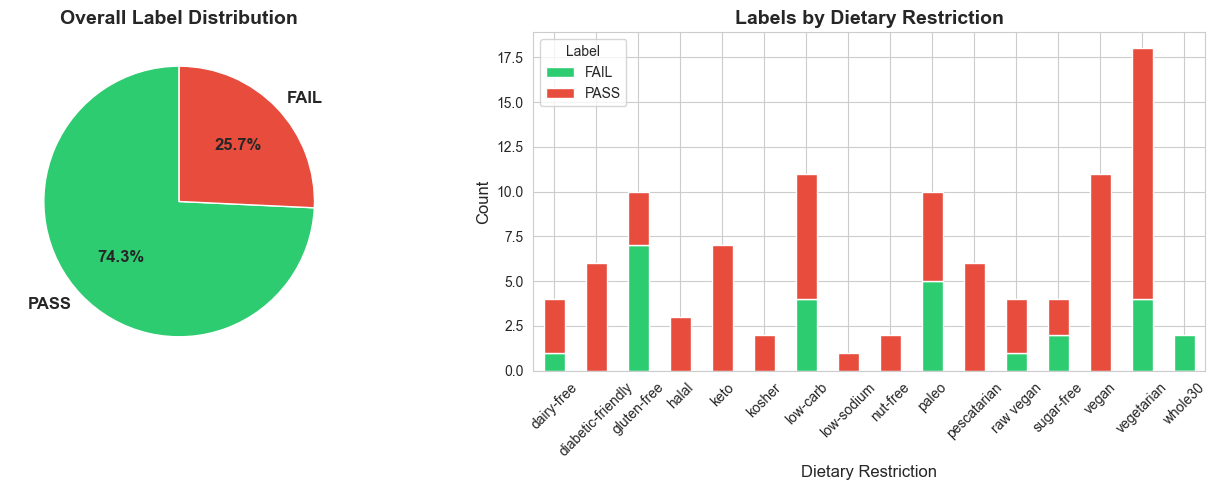

In [9]:
# Overall label distribution
label_counts = df_labeled['label'].value_counts()
pass_count = label_counts.get('PASS', 0)
fail_count = label_counts.get('FAIL', 0)
total = len(df_labeled)

print("📊 Label Distribution:")
print(f"PASS: {pass_count} ({pass_count/total:.1%})")
print(f"FAIL: {fail_count} ({fail_count/total:.1%})")
print(f"Total: {total}")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = ['#2ecc71', '#e74c3c']
ax1.pie([pass_count, fail_count], labels=['PASS', 'FAIL'], autopct='%1.1f%%', 
        colors=colors, startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
ax1.set_title('Overall Label Distribution', fontsize=14, fontweight='bold')

# Bar chart by dietary restriction
label_by_restriction = df_labeled.groupby(['dietary_restriction', 'label']).size().unstack(fill_value=0)
label_by_restriction.plot(kind='bar', stacked=True, ax=ax2, color=colors)
ax2.set_title('Labels by Dietary Restriction', fontsize=14, fontweight='bold')
ax2.set_xlabel('Dietary Restriction', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.legend(title='Label', fontsize=10)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Check for Imbalance

**Ideal:** 40-60% PASS rate  
**Problematic:** <30% or >70% PASS rate

If labels are highly imbalanced, consider:
1. Generating more traces with underrepresented outcomes
2. Stratified sampling to balance train/dev/test splits

In [10]:
# Check balance
pass_rate = pass_count / total

if 0.4 <= pass_rate <= 0.6:
    print(f"✅ Well-balanced dataset: {pass_rate:.1%} PASS rate")
elif 0.3 <= pass_rate <= 0.7:
    print(f"⚠️  Slightly imbalanced: {pass_rate:.1%} PASS rate (acceptable but could be better)")
else:
    print(f"❌ Highly imbalanced: {pass_rate:.1%} PASS rate")
    print("Consider generating more traces or using stratified sampling")

❌ Highly imbalanced: 74.3% PASS rate
Consider generating more traces or using stratified sampling


## Part 5: Stratified Data Splitting

### Why Stratified Splitting?

**Problem:** Random splitting might create imbalanced sets:  
- Train: 80% PASS
- Dev: 45% PASS
- Test: 60% PASS

**Solution:** Stratified splitting ensures each set has similar PASS/FAIL proportions.

### Split Ratios

- **Train: 15%** - Few-shot examples for judge prompt
- **Dev: 40%** - Iterative refinement and testing
- **Test: 45%** - Final evaluation (use only once!)

In [11]:
def stratified_split(df: pd.DataFrame, 
                    train_ratio: float = 0.15,
                    dev_ratio: float = 0.40,
                    test_ratio: float = 0.45,
                    random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Split dataframe into train/dev/test with stratification by label."""
    
    # Validate ratios
    assert abs(train_ratio + dev_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"
    
    # First split: separate train from (dev + test)
    train_df, temp_df = train_test_split(
        df, 
        test_size=(dev_ratio + test_ratio),
        stratify=df['label'],
        random_state=random_state
    )
    
    # Second split: separate dev from test
    dev_test_ratio = dev_ratio / (dev_ratio + test_ratio)
    dev_df, test_df = train_test_split(
        temp_df,
        test_size=(1 - dev_test_ratio),
        stratify=temp_df['label'],
        random_state=random_state
    )
    
    return train_df, dev_df, test_df

# Perform split
train_df, dev_df, test_df = stratified_split(df_labeled)

print("✅ Data split completed:")
print(f"Train: {len(train_df)} examples ({len(train_df)/len(df_labeled):.1%})")
print(f"Dev: {len(dev_df)} examples ({len(dev_df)/len(df_labeled):.1%})")
print(f"Test: {len(test_df)} examples ({len(test_df)/len(df_labeled):.1%})")

✅ Data split completed:
Train: 15 examples (14.9%)
Dev: 40 examples (39.6%)
Test: 46 examples (45.5%)


### Verify Split Quality

Check that PASS/FAIL ratios are similar across all splits:

In [ ]:
# ========================================
# VALIDATION: Verify split stratification
# ========================================

# Assert splits sum to original data
total_split = len(train_df) + len(dev_df) + len(test_df)
assert total_split == len(df_labeled), f"Split sizes don't match: {total_split} != {len(df_labeled)}"

# Assert no overlap between splits
train_ids = set(train_df.index)
dev_ids = set(dev_df.index)
test_ids = set(test_df.index)

assert len(train_ids & dev_ids) == 0, "Train and dev sets overlap"
assert len(train_ids & test_ids) == 0, "Train and test sets overlap"
assert len(dev_ids & test_ids) == 0, "Dev and test sets overlap"

# Assert stratification quality (PASS rate should be similar across splits)
train_pass_rate = (train_df['label'] == 'PASS').sum() / len(train_df)
dev_pass_rate = (dev_df['label'] == 'PASS').sum() / len(dev_df)
test_pass_rate = (test_df['label'] == 'PASS').sum() / len(test_df)

pass_rates = [train_pass_rate, dev_pass_rate, test_pass_rate]
max_diff = max(pass_rates) - min(pass_rates)

assert max_diff < 0.15, f"Poor stratification: PASS rate varies by {max_diff:.1%}"

# Assert minimum examples per split
assert len(train_df) >= 10, f"Train set too small: {len(train_df)} examples"
assert len(dev_df) >= 20, f"Dev set too small: {len(dev_df)} examples"
assert len(test_df) >= 20, f"Test set too small: {len(test_df)} examples"

print("✅ VALIDATION PASSED:")
print("   - No overlap between splits")
print(f"   - Splits sum to original dataset ({total_split} examples)")
print(f"   - Good stratification (max PASS rate diff: {max_diff:.1%})")
print("   - All splits have sufficient examples")
print(f"   - Train: {len(train_df)} | Dev: {len(dev_df)} | Test: {len(test_df)}")


📊 Split Statistics:


,Split,Total,PASS,FAIL,PASS%,FAIL%
0,Train,15,11,4,73.3%,26.7%
1,Dev,40,30,10,75.0%,25.0%
2,Test,46,34,12,73.9%,26.1%


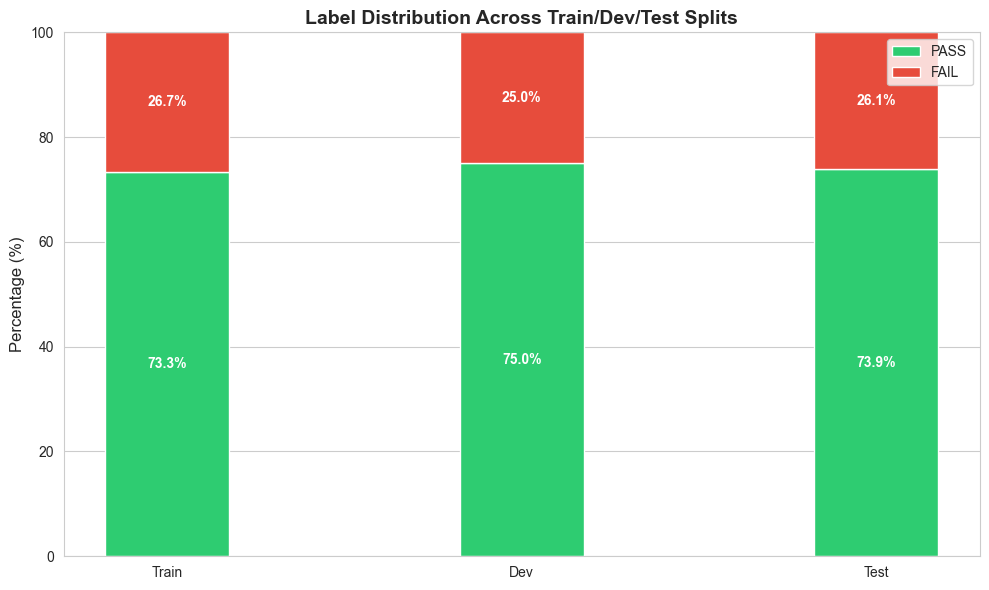


✅ Excellent stratification: PASS rate std dev = 0.007


In [13]:
# Calculate label distributions for each split
def get_split_stats(df: pd.DataFrame, split_name: str) -> Dict[str, Any]:
    """Get statistics for a data split."""
    label_counts = df['label'].value_counts()
    pass_count = label_counts.get('PASS', 0)
    fail_count = label_counts.get('FAIL', 0)
    total = len(df)
    
    return {
        'Split': split_name,
        'Total': total,
        'PASS': pass_count,
        'FAIL': fail_count,
        'PASS%': f"{pass_count/total:.1%}",
        'FAIL%': f"{fail_count/total:.1%}"
    }

# Create summary table
stats = [
    get_split_stats(train_df, 'Train'),
    get_split_stats(dev_df, 'Dev'),
    get_split_stats(test_df, 'Test')
]

stats_df = pd.DataFrame(stats)
print("\n📊 Split Statistics:")
display(stats_df)

# Visualize split balance
fig, ax = plt.subplots(figsize=(10, 6))

splits = ['Train', 'Dev', 'Test']
pass_pcts = [stats[i]['PASS'] / stats[i]['Total'] * 100 for i in range(3)]
fail_pcts = [stats[i]['FAIL'] / stats[i]['Total'] * 100 for i in range(3)]

x = np.arange(len(splits))
width = 0.35

ax.bar(x, pass_pcts, width, label='PASS', color='#2ecc71')
ax.bar(x, fail_pcts, width, bottom=pass_pcts, label='FAIL', color='#e74c3c')

ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Label Distribution Across Train/Dev/Test Splits', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(splits)
ax.legend(fontsize=10)
ax.set_ylim(0, 100)

# Add percentage labels
for i, (split, pass_pct, fail_pct) in enumerate(zip(splits, pass_pcts, fail_pcts)):
    ax.text(i, pass_pct/2, f'{pass_pct:.1f}%', ha='center', va='center', fontweight='bold', color='white')
    ax.text(i, pass_pct + fail_pct/2, f'{fail_pct:.1f}%', ha='center', va='center', fontweight='bold', color='white')

plt.tight_layout()
plt.show()

# Validation check
pass_rates = [stats[i]['PASS'] / stats[i]['Total'] for i in range(3)]
pass_rate_std = np.std(pass_rates)

if pass_rate_std < 0.05:
    print(f"\n✅ Excellent stratification: PASS rate std dev = {pass_rate_std:.3f}")
elif pass_rate_std < 0.10:
    print(f"\n⚠️  Acceptable stratification: PASS rate std dev = {pass_rate_std:.3f}")
else:
    print(f"\n❌ Poor stratification: PASS rate std dev = {pass_rate_std:.3f}")
    print("Consider increasing labeled data or adjusting split strategy")

## Part 6: Export Splits

Save the train/dev/test splits for use in judge development and evaluation:

In [14]:
# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Save splits
train_df.to_csv('data/train_set.csv', index=False)
dev_df.to_csv('data/dev_set.csv', index=False)
test_df.to_csv('data/test_set.csv', index=False)

print("✅ Saved data splits:")
print(f"  - data/train_set.csv ({len(train_df)} examples)")
print(f"  - data/dev_set.csv ({len(dev_df)} examples)")
print(f"  - data/test_set.csv ({len(test_df)} examples)")

✅ Saved data splits:
  - data/train_set.csv (15 examples)
  - data/dev_set.csv (40 examples)
  - data/test_set.csv (46 examples)


## Part 7: Validation and Quality Checks

### Manual Review Sample

Always manually review a sample of labels, especially if using automated labeling:

In [15]:
# Sample 5 random examples for manual review
review_sample = df_labeled.sample(n=min(5, len(df_labeled)), random_state=42)

print("🔍 Manual Review Sample (verify these labels are correct):\n")

for idx, row in review_sample.iterrows():
    print(f"{'='*80}")
    print(f"Example {idx + 1}:")
    print(f"Query: {row['query']}")
    print(f"Dietary Restriction: {row['dietary_restriction']}")
    print(f"Response (first 300 chars): {str(row['response'])[:300]}...")
    print(f"\n✓ Label: {row['label']}")
    if 'reasoning' in row:
        print(f"Reasoning: {row['reasoning'][:200]}...")
    print("\n⚠️  Is this label correct? (Manually verify)\n")

🔍 Manual Review Sample (verify these labels are correct):

Example 85:
Query: Low-carb pizza recipe - I miss pizza so much
Dietary Restriction: low-carb
Response (first 300 chars): Absolutely! Here's a delicious low-carb cauliflower crust pizza recipe perfect for satisfying your pizza cravings. This recipe serves 2 people.

### Cauliflower Crust Pizza (Low-Carb)

#### Ingredients:
- 1 medium cauliflower head (about 4 cups of florets)
- 1 large egg
- 1/2 cup shredded mozzarella...

✓ Label: PASS
Reasoning: The recipe for cauliflower crust pizza adheres to the low-carb dietary restriction. The primary ingredient for the crust is cauliflower, which is low in carbohydrates. The use of mozzarella and Parmes...

⚠️  Is this label correct? (Manually verify)

Example 56:
Query: Gluten-free pizza dough that actually tastes good and isn't cardboard
Dietary Restriction: gluten-free
Response (first 300 chars): Absolutely! Here's a delicious gluten-free pizza dough recipe that’s flavorful, tender, 

### Confidence Distribution (if available)

📊 Confidence Distribution:
confidence
HIGH      94
MEDIUM     7
Name: count, dtype: int64

⚠️  LOW confidence examples: 0 (0.0%)
These should be manually reviewed first!


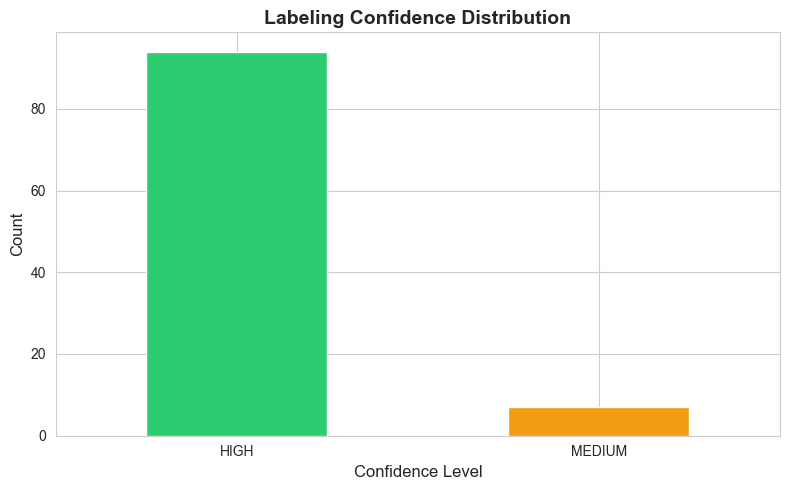

In [16]:
if 'confidence' in df_labeled.columns:
    confidence_counts = df_labeled['confidence'].value_counts()
    
    print("📊 Confidence Distribution:")
    print(confidence_counts)
    print(f"\n⚠️  LOW confidence examples: {confidence_counts.get('LOW', 0)} ({confidence_counts.get('LOW', 0)/len(df_labeled):.1%})")
    print("These should be manually reviewed first!")
    
    # Plot confidence distribution
    plt.figure(figsize=(8, 5))
    confidence_counts.plot(kind='bar', color=['#2ecc71', '#f39c12', '#e74c3c'])
    plt.title('Labeling Confidence Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Confidence Level', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## Summary

### What We've Accomplished

✅ Loaded and explored raw Recipe Bot traces  
✅ Understood manual vs. automated labeling trade-offs  
✅ Demonstrated automated labeling with GPT-4o  
✅ Analyzed label distribution and identified balance  
✅ Created stratified train/dev/test splits (15%/40%/45%)  
✅ Validated split quality and consistency  
✅ Exported splits for judge development  

### Next Steps

1. **Manually review** at least 30-50% of labels (especially LOW confidence examples)
2. **Correct any labeling errors** you find during review
3. **Move to judge development**: [Judge Development Tutorial](judge_development_tutorial.ipynb)
4. Use **train set** for few-shot examples in judge prompt
5. Use **dev set** for iterative prompt refinement
6. Use **test set** only once for final TPR/TNR calculation

### Key Takeaways

- ✅ **Ground truth quality is critical** - Invest time in labeling or validation
- ✅ **Automated labeling requires manual validation** - Never trust labels blindly
- ✅ **Stratified splitting ensures fair evaluation** - Each set should be representative
- ✅ **Balance matters** - Aim for 40-60% PASS rate when possible
- ✅ **Test set is sacred** - Use it only once at the very end

---

**Tutorial Status:** ✅ Complete  
**Last Updated:** 2025-10-29  
**Maintainer:** AI Evaluation Course Team